In [4]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [48]:
file_path = '../Features/Large/selected_features_CorrVar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,...,RingCount,MolLogP,fr_C_O,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_amide,fr_aniline,fr_ether,fr_halogen
0,0,0.545511,0.223433,0.490223,0.390551,0.291325,0.250000,0.472316,0.592036,-1.017995,...,0.447214,0.451534,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
1,1,0.591920,0.253125,0.601726,0.389406,0.277681,0.278846,0.315886,0.215424,1.052267,...,0.447214,0.416318,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
2,1,0.553126,0.334919,0.502072,0.400859,0.399452,0.278846,0.472195,0.592036,-1.018511,...,0.447214,0.475805,0.0,0.000000,0.707107,0.0,0.0,0.0,0.000000,0.707107
3,0,0.612445,0.602032,0.496240,0.408749,0.461148,0.423077,0.676377,0.290413,0.491735,...,0.000000,0.560347,0.5,0.707107,0.000000,0.0,0.0,0.0,0.707107,0.000000
4,0,0.618170,0.914475,0.141109,0.000000,0.000000,0.000000,0.354992,0.378416,-0.071536,...,0.000000,0.225586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [49]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [50]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1989, 97)
Shape of X_test: (498, 97)
Shape of y_train: (1989,)
Shape of y_test: (498,)


In [63]:

def objective(trial):
    # Define hyperparameter search space
    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),  # Gini or Entropy
        "max_depth": trial.suggest_int("max_depth", 5, 15),  # Depth between 5 and 15 (to avoid overfitting)
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),  # Min samples to split: 5-20 to ensure nodes have enough data
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),  # Min samples in leaf: avoid overly small leaves
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2", 0.3, 0.5]),  # Feature selection: 0.3 to 0.5 fraction of features
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 100),  # Control number of leaf nodes (higher values for more complexity)
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.05),  # Threshold for impurity reduction
        "splitter": trial.suggest_categorical("splitter", ["best", "random"]),  # 'best' vs 'random' split strategy
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),  # Handle class imbalance if needed
    }


    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = DecisionTreeClassifier(**params, random_state=42)
    
    # Evaluate model using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1)
    return scores.mean()  # Maximize accuracy

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best parameters:", study.best_trial.params)

# Train final Decision Tree model with best parameters
best_params = study.best_trial.params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-03-09 15:32:03,677] A new study created in memory with name: no-name-608d363b-bed1-48c9-a739-0f37ccc6c76f
[I 2025-03-09 15:32:03,907] Trial 0 finished with value: 0.5153348607014923 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 0.3, 'max_leaf_nodes': 47, 'min_impurity_decrease': 0.031163953769832678, 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5153348607014923.
[I 2025-03-09 15:32:04,080] Trial 1 finished with value: 0.6616584180347582 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_leaf_nodes': 47, 'min_impurity_decrease': 0.02853681234466578, 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6616584180347582.
[I 2025-03-09 15:32:04,228] Trial 2 finished with value: 0.5153348607014923 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split'

Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 0.3, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0027097139417430467, 'splitter': 'best', 'class_weight': 'balanced'}
Final Model Accuracy: 0.7028112449799196


Final Model Accuracy on Test: 0.7028112449799196


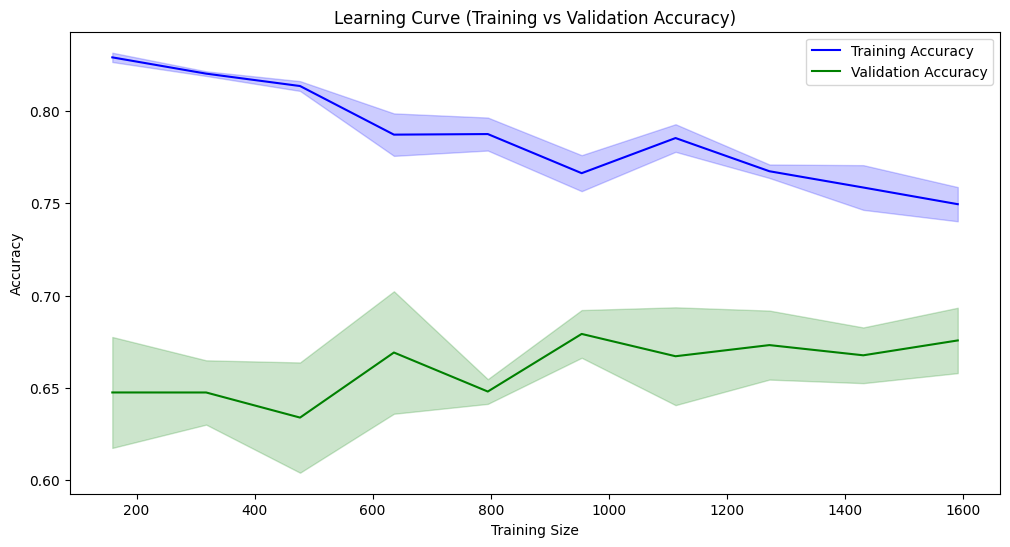

Train Accuracy: 0.751131221719457
Test Accuracy: 0.7028112449799196


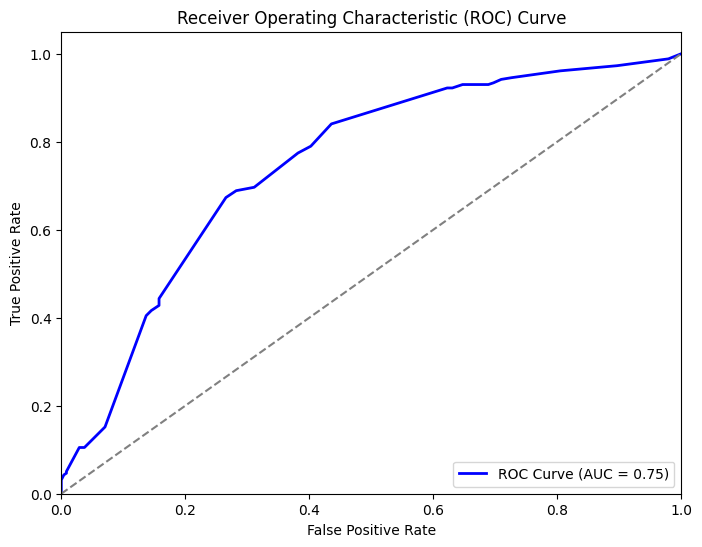

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve

# Get best hyperparameters from Optuna study
best_params = study.best_trial.params
best_params.pop("use_max_leaf_nodes", None)  # Remove invalid key

# Initialize the Decision Tree model
final_model = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the model
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# ==============================
# Learning Curve Plot
# ==============================

# Compute learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print Train and Test Accuracy
print("Train Accuracy:", final_model.score(X_train, y_train))
print("Test Accuracy:", final_model.score(X_test, y_test))

# ==============================
# ROC Curve Plot (Only for Classification)
# ==============================

# Ensure model supports predict_proba (classification case)
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve cannot be plotted. Model does not support probability predictions.")


Best max_depth based on test accuracy: 8
Best Training Accuracy: 0.8431
Best Testing Accuracy: 0.7410
Best max_depth based on bias-variance tradeoff: 3


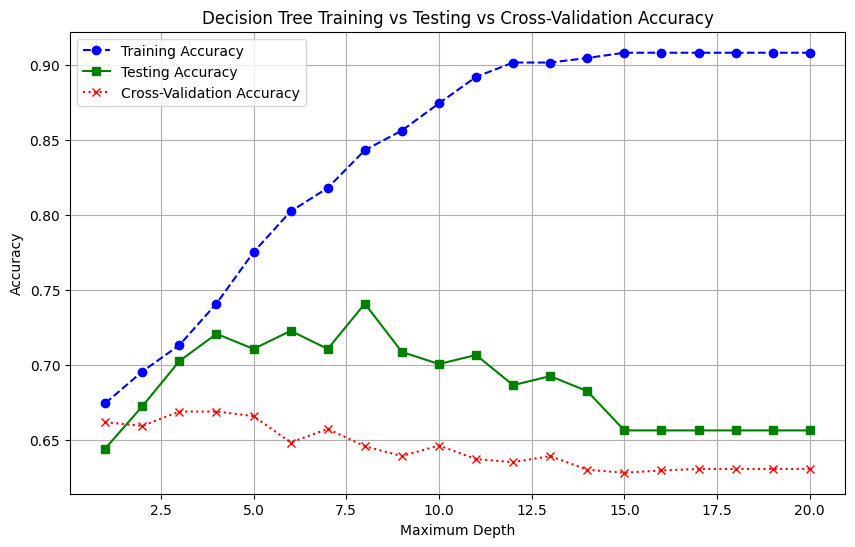

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define range of max_depth values
depth_values = range(1, 21)  # Limiting depth from 1 to 20
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Iterate over different depth values
best_depth = 1
best_test_acc = 0
best_train_acc = 0
best_tradeoff_depth = 1
best_tradeoff_value = float('inf')

for depth in depth_values:
    # Regularization via min_samples_split and min_samples_leaf
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=10, min_samples_leaf=5, random_state=42)
    model.fit(X_train, y_train)  # Train the model
    
    # Compute training and test accuracy
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Perform cross-validation (5-fold)
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cv_accuracies.append(cv_acc)
    
    # Track best depth based on test accuracy
    if test_acc > best_test_acc:
        best_depth = depth
        best_test_acc = test_acc
        best_train_acc = train_acc
    
    # Find the best tradeoff between bias and variance
    tradeoff_value = abs(train_acc - test_acc)
    if tradeoff_value < best_tradeoff_value:
        best_tradeoff_value = tradeoff_value
        best_tradeoff_depth = depth

# Print best depth and corresponding accuracy
print(f"Best max_depth based on test accuracy: {best_depth}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Testing Accuracy: {best_test_acc:.4f}")
print(f"Best max_depth based on bias-variance tradeoff: {best_tradeoff_depth}")

# Plot training vs testing vs cross-validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(depth_values, train_accuracies, label='Training Accuracy', marker='o', linestyle='dashed', color='blue')
plt.plot(depth_values, test_accuracies, label='Testing Accuracy', marker='s', linestyle='solid', color='green')
plt.plot(depth_values, cv_accuracies, label='Cross-Validation Accuracy', marker='x', linestyle='dotted', color='red')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Training vs Testing vs Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


TypeError: 'value' must be an instance of str or bytes, not a None

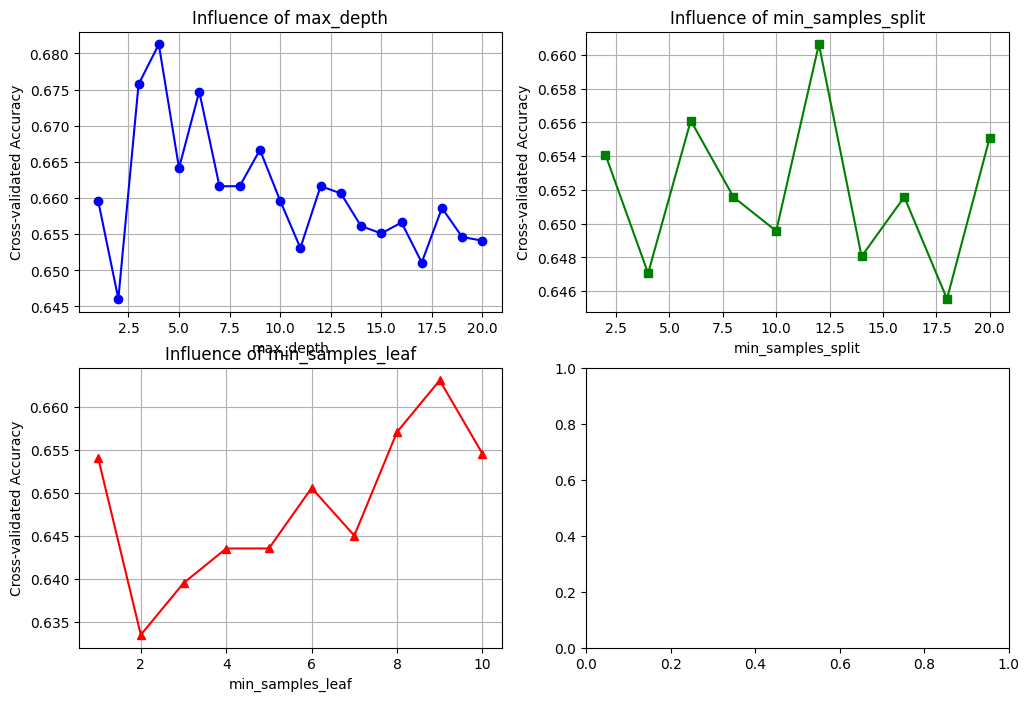

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Define the hyperparameter values to tune
max_depth_values = range(1, 21)
min_samples_split_values = range(2, 21, 2)
min_samples_leaf_values = range(1, 11)
max_features_values = [None, 'sqrt', 'log2']

# Store accuracy scores for different hyperparameters
depth_accuracies = []
split_accuracies = []
leaf_accuracies = []
features_accuracies = []

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over max_depth values
for depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    depth_accuracies.append(cv_score)

# Iterate over min_samples_split values
for split in min_samples_split_values:
    model = DecisionTreeClassifier(min_samples_split=split, random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    split_accuracies.append(cv_score)

# Iterate over min_samples_leaf values
for leaf in min_samples_leaf_values:
    model = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    leaf_accuracies.append(cv_score)

# Iterate over max_features values
for features in max_features_values:
    model = DecisionTreeClassifier(max_features=features, random_state=42)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    features_accuracies.append(cv_score)

# Plot the influence of max_depth on accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(max_depth_values, depth_accuracies, marker='o', linestyle='-', color='b')
plt.title('Influence of max_depth')
plt.xlabel('max_depth')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)

# Plot the influence of min_samples_split on accuracy
plt.subplot(2, 2, 2)
plt.plot(min_samples_split_values, split_accuracies, marker='s', linestyle='-', color='g')
plt.title('Influence of min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)

# Plot the influence of min_samples_leaf on accuracy
plt.subplot(2, 2, 3)
plt.plot(min_samples_leaf_values, leaf_accuracies, marker='^', linestyle='-', color='r')
plt.title('Influence of min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)

# Plot the influence of max_features on accuracy
plt.subplot(2, 2, 4)
plt.plot(max_features_values, features_accuracies, marker='x', linestyle='-', color='m')
plt.title('Influence of max_features')
plt.xlabel('max_features')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'dt_model.pkl')

print("Model saved successfully!")


Model saved successfully!
